In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
df = pd.read_csv('HousingData.csv')

In [3]:
# to view all columns of the database in the output window
pd.set_option('display.max_columns',None)

In [4]:
# seeing which all features have missing values
df.isna().sum()

CRIM       20
ZN         20
INDUS      20
CHAS       20
NOX         0
RM          0
AGE        20
DIS         0
RAD         0
TAX         0
PTRATIO     0
B           0
LSTAT      20
MEDV        0
dtype: int64

In [5]:
# the columns with missing values are CRIM, ZN, INDUS, CHAS, AGE, and LSTAT, each with 20 missing values. The target variable MEDV does not have any missing values.

In [6]:
df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,NaN,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,NaN,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1,273,21.0,393.45,6.48,22.0


In [7]:
df.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'MEDV'],
      dtype='object')

In [8]:
# Can we drop rows which have NaN values?
missing_row_count = df.isna().any(axis=1).sum() # Count of rows with at least one missing (NaN) value
print(missing_row_count)
#number of rows in the dataframe
len(df)

#since dropping 112 rows would make our dataset very small, we will impute missing values in the features

112


506

/var/folders/z0/f8x0px094r52y2v2fgmzyqmr0000gn/T/ipykernel_12843/1497194269.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab10', len(missing_features))  # Clean color palette


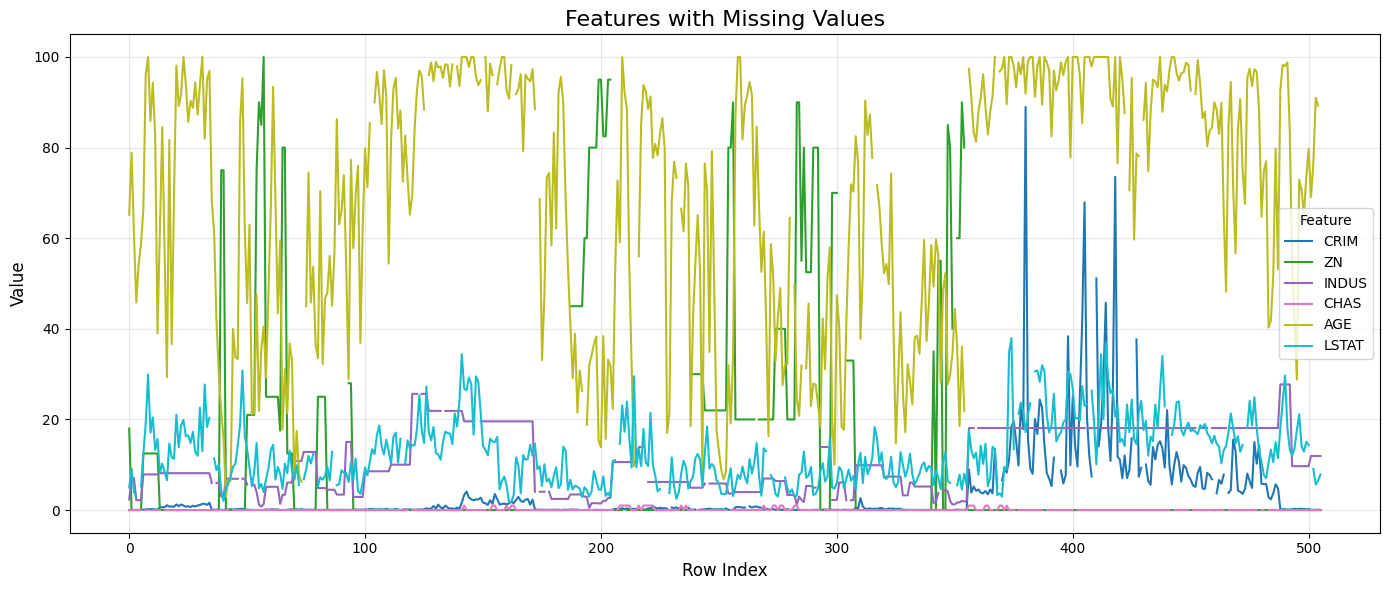

In [9]:
"""
Plotting all features with missing values on the y-axis against row index helps us:

- Visually inspect the **shape and structure** of each feature (e.g., smooth, noisy, or plateaued).
- Identify whether features exhibit **collinearity** or similar patterns — useful when deciding KNN-based imputation.
- Detect features that are **too erratic or zigzagged**, where local imputation (like KNN or interpolation) may be unreliable.
- Understand whether values change **gradually or abruptly** across the dataset, which can influence imputation strategy.

This kind of visualization provides intuition for selecting the most appropriate imputation method: 
mean/median for noisy distributions, KNN for locally structured features, and possibly dropping rows/features that are unstable or uninformative.
"""

"""
Should we normalise before plotting?
No
When you're visually inspecting each feature individually, you usually want to preserve their original scale and units, because that reflects the real-world meaning (e.g., AGE is in %, TAX is per $10k).
You don't want to flatten or distort shapes via scaling before assessing their structure.
For plots like your value vs. index, it's good to see actual values, not rescaled ones.
"""

# Features with missing values
missing_features = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'AGE', 'LSTAT']
colors = cm.get_cmap('tab10', len(missing_features))  # Clean color palette

plt.figure(figsize=(14, 6))

for i, feature in enumerate(missing_features):
    plt.plot(df.index, df[feature], label=feature, color=colors(i), linewidth=1.5)

plt.title("Features with Missing Values", fontsize=16)
plt.xlabel("Row Index", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.legend(title="Feature", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [10]:
"""
Exploring collinearity between AGE and LSTAT to assess whether one can be used to impute the other.
1. However, since both features contain missing values, using one to impute the other may introduce circular logic.
2. This is problematic because each depends on incomplete information, making such imputation unreliable without prior handling.

What can be done instead:
- Impute one with a simpler method first (e.g., median for AGE),
- Then use it to impute the other (e.g., LSTAT via regression or KNN),
- Or exclude rows where both are missing if that’s acceptable and rare.
"""
df[['AGE', 'LSTAT']].corr()

,AGE,LSTAT
AGE,1.000000,0.602891
LSTAT,0.602891,1.000000


In [11]:
# imputing CHAS
df['CHAS'].value_counts()
# since CHAS is a categorical feature which is heavily imbalanced towards 0, we can impute missing values with 0, as it reflects the mode. And avoids introducing rare class bias (imputing 1s by mistake).
chas_mode = df['CHAS'].mode()[0]
df['CHAS'].fillna(chas_mode, inplace=True)